In [1]:
from mteb import MTEB
import mteb, pickle, os, sys, json, glob, umap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sentence_transformers import SentenceTransformer
from llama_index.core.schema import NodeRelationship


# MTEB embedding model evaluation

In [5]:
model_names = { "BAAI/bge-small-en-v1.5",
                "all-mpnet-base-v2",
                "BAAI/bge-m3",
                "all-MiniLM-L6-v2",  
                "all-MiniLM-L12-v2"}
                
tasks = mteb.get_tasks(tasks=["MedicalQARetrieval", "NFCorpus", "CUREv1", "MedrxivClusteringP2P.v2", "MedrxivClusteringS2S.v2"], languages=["eng"], domains=["Medical"]) # 
evaluation = MTEB(tasks)

In [ ]:
for name in model_names:
    model = SentenceTransformer(name)
    evaluation = MTEB(tasks)
    if "BAAI/" in name:
        name = name.replace("BAAI/", "")
    results = evaluation.run(model, output_folder=f"results/{name}")


In [6]:
tasks.to_dataframe()[['name', 'type']]

,name,type
0,MedicalQARetrieval,Retrieval
1,NFCorpus,Retrieval
2,CUREv1,Retrieval
3,MedrxivClusteringP2P.v2,Clustering
4,MedrxivClusteringS2S.v2,Clustering


In [11]:
# Retrieve task names and initialize results_dict directly
task_info = tasks.to_dataframe()[['name', 'type']].rename(columns={'name': 'task'})
task_info = task_info.set_index('task')  # Set 'task' as the index for easier manipulation
task_info = task_info.assign(**{model.split('/')[-1]: None for model in model_names})  # Add model columns with None values

# Process JSON files and populate task_info
for file in glob.glob("/home/lasa14/scratch-llm/results/MTEB/**/*.json", recursive=True):
    try:
        with open(file, 'r') as f:
            data = json.load(f)
            task_name = data.get("task_name")
            model_name = next((model.split('/')[-1] for model in model_names if model.split('/')[-1] in file), None)
            main_score = data.get("scores", {}).get("test", [{}])[0].get("main_score") or \
                         data.get("scores", {}).get("all", [{}])[0].get("main_score")

            if task_name in task_info.index and model_name in task_info.columns:
                task_info.at[task_name, model_name] = main_score
    except json.JSONDecodeError:
        print(f"Error decoding JSON in file: {file}")

# Reset index and reorder columns to move 'type' to the second position
results_df = task_info.reset_index()
results_df = results_df[['task', 'type'] + [col for col in results_df.columns if col not in ['task', 'type']]]

# Display the results DataFrame
results_df

,task,type,bge-m3,all-mpnet-base-v2,all-MiniLM-L6-v2,all-MiniLM-L12-v2,bge-small-en-v1.5
0,MedicalQARetrieval,Retrieval,0.68098,0.66517,0.60299,0.62038,0.65558
1,NFCorpus,Retrieval,0.31411,0.33289,0.31594,0.3225,0.33708
2,CUREv1,Retrieval,0.54524,0.34946,0.3377,0.34691,0.45933
3,MedrxivClusteringP2P.v2,Clustering,0.339501,0.398618,0.3749,0.378205,0.36186
4,MedrxivClusteringS2S.v2,Clustering,0.30463,0.369813,0.357328,0.359373,0.351683


In [ ]:
latex = results_df.to_latex(
    index=False, 
    column_format='|l|l||c|c|c|c|c|',
    position="htbp",  # The preferred positions where the table should be placed in the document ('here', 'top', 'bottom', 'page')
    escape=False,  # Do not escape special characters
    float_format="{:0.4f}".format,  # Format floating-point numbers to 4 decimal places
    caption="Results of MTEB tasks for different models",  # Caption for the table
    label="tab:mteb_results",  # Label for referencing the table in LaTeX
)
with open(os.path.expanduser("~/scratch-llm/results/latex_table.txt"), "w") as f:
    f.write(latex)

# Generate subgraph

In [3]:
#import nodes from pickle from the storage
# with open(os.path.expanduser('~/scratch-llm/storage/nodes/all_nodes_embedded_mpnet_base_v2.pkl'), 'rb') as f:
with open(os.path.expanduser('~/scratch-llm/storage/nodes/all_nodes_all-mpnet-base-v2.pkl'), 'rb') as f:
    all_nodes_embedded = pickle.load(f)

## Find nodes that have edges of multiple types:

In [ ]:
from collections import defaultdict
from tqdm.notebook import tqdm  # Import tqdm for progress bar

# Create a dictionary to map node IDs to nodes for faster lookup
node_dict = {node.node_id: node for node in all_nodes_embedded}

# Create a dictionary to track connections between node types
node_type_connections = defaultdict(set)

# Iterate through all nodes and their relationships with a progress bar
for node in tqdm(all_nodes_embedded, desc="Processing nodes"):
    for rel in node.relationships.get(NodeRelationship.CHILD, []):
        target_node = node_dict.get(rel.node_id)  # Use dictionary lookup instead of searching the list
        if target_node:
            target_node_type = target_node.metadata.get('node_type', 'unknown')
            node_type_connections[node.node_id].add(target_node_type)

# Find all nodes connected to at least 4 different types
def find_nodes_with_four_types(node_type_connections):
    nodes_with_four_types = []
    for node_id, connected_types in node_type_connections.items():
        if len(connected_types) >= 10:
            nodes_with_four_types.append((node_id, connected_types))
    return nodes_with_four_types

nodes_with_four_types = find_nodes_with_four_types(node_type_connections)

# Store the nodes with at least 4 different types
if nodes_with_four_types:
    print(f"Found {len(nodes_with_four_types)} nodes with connections to at least 4 different types.")
    for node_id, connected_types in nodes_with_four_types:
        print(f"Node ID: {node_id}, Connected Types: {connected_types}")
else:
    print("No nodes found with connections to at least 4 different types.")

In [ ]:
node_index = next((i for i, node in enumerate(all_nodes_embedded) if node.node_id == "12120"), None)
node_index

98971

## Obtain the nodes from the subgraph

In [2]:
#small subgraph with text nodes

def generate_subgraph(all_nodes_embedded):
    """
    Generate a subgraph from the given node embeddings.
    """
    subgraph_nodes = []
    start_node = all_nodes_embedded[98971]
    related_nodes_info = start_node.relationships.get(NodeRelationship.CHILD, [])

    related_nodes = []
    edges = []
    for relation in related_nodes_info:
        # Find the related node by its node_id
        related_node = next((node for node in all_nodes_embedded if node.node_id == relation.node_id), None)
        if related_node:
            related_nodes.append(related_node)
            edges.append((start_node.node_id, related_node.node_id, relation.metadata))
    subgraph_nodes = [start_node] + related_nodes  # Include the starting node and its neighbors
    return subgraph_nodes


In [6]:
subgraph_nodes = generate_subgraph(all_nodes_embedded)

### UMAP


In [ ]:
# plot the embeddings from the subgraph with UMAP
reducer = umap.UMAP(n_components=2, random_state=42)

embeddings = np.array([node.embedding for node in subgraph_nodes])
embeddings_reduced = reducer.fit_transform(embeddings)
embeddings_reduced.shape
# plot the embeddings according to the "node_type" from the reduced_embeddings variable
plt.figure(figsize=(10, 8))  # Increase the figure size

# Convert labels to numerical values for coloring
labels = [node.metadata['node_type'] for node in subgraph_nodes]
label_to_num = {label: idx for idx, label in enumerate(set(labels))}
numeric_labels = [label_to_num[label] for label in labels]

legend_labels = list(label_to_num.keys())

# Create a scatter plot of the reduced embeddings

scatter = plt.scatter(embeddings_reduced[:, 0], embeddings_reduced[:, 1], c=numeric_labels, cmap='tab10')
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Node Types", loc="upper left")
plt.title("Node Embeddings with UMAP")
plt.show()

/home/lasa14/.conda/envs/llm-rag/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lasa14/.conda/envs/llm-rag/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(180, 2)

In [ ]:
def plot_subgraph(subgraph_nodes, embedding_files):
    """
    Plot the node embeddings of the subgraph using t-SNE for dimensionality reduction.
    Each embedding model is visualized in a separate subplot, with a single legend for all plots.
    """
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))  # Adjusted figure size for better readability
    axs = axs.flat  # Flatten the axes array for easier indexing

    # Dictionary to collect labels and colors for the single legend
    label_to_num_global = {}

    for i, embedding_file in enumerate(embedding_files):
        if i >= len(axs):  # Ensure we don't exceed the number of subplots
            break
        
        print(f"Loading file: {embedding_file}")
        # Load the embeddings for the current model
        with open(os.path.expanduser(f'~/scratch-llm/storage/nodes/{embedding_file}'), 'rb') as f:
            all_nodes_embedded = pickle.load(f)

        # Generate the subgraph
        subgraph_nodes = generate_subgraph(all_nodes_embedded)

        # Extract embeddings and labels
        embeddings = np.array([node.embedding for node in subgraph_nodes])
        labels = [node.metadata['node_type'] for node in subgraph_nodes]

        # Perform UMAP dimensionality reduction
        reducer = umap.UMAP(n_components=2, random_state=42)
        reduced_embeddings = reducer.fit_transform(embeddings)

        # Convert labels to numerical values for coloring
        for label in labels:
            if label not in label_to_num_global:
                label_to_num_global[label] = len(label_to_num_global)
        numeric_labels = [label_to_num_global[label] for label in labels]

        # Plot the embeddings in the current subplot
        scatter = axs[i].scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=numeric_labels, cmap='tab10')

        # Add title
        axs[i].set_title(f"Model: {embedding_file.split('/')[-1]}")

    # Remove unused subplots
    for j in range(len(embedding_files), len(axs)):
        axs[j].axis('off')

    # Create a single legend for all plots
    legend_labels = list(label_to_num_global.keys())
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(label_to_num_global[label]), markersize=10) for label in legend_labels]
    fig.legend(handles, legend_labels, title="Node Types", loc="upper center", ncol=5)

    plt.tight_layout(pad=3.0)
    plt.show()

# List of embedding files
embedding_files = [
    "all_nodes_all-mpnet-base-v2.pkl",
    "all_nodes_bge-m3.pkl",
    # "all_nodes_bge-small-en-v1.5.pkl",
    # "all_nodes_all-MiniLM-L6-v2.pkl",
    # "all_nodes_all-MiniLM-L12-v2.pkl",
]

# Call the function to plot the subgraph
plot_subgraph(subgraph_nodes=None, embedding_files=embedding_files)

Loading file: all_nodes_all-mpnet-base-v2.pkl


/home/lasa14/.conda/envs/llm-rag/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lasa14/.conda/envs/llm-rag/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Loading file: all_nodes_bge-m3.pkl


/home/lasa14/.conda/envs/llm-rag/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lasa14/.conda/envs/llm-rag/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


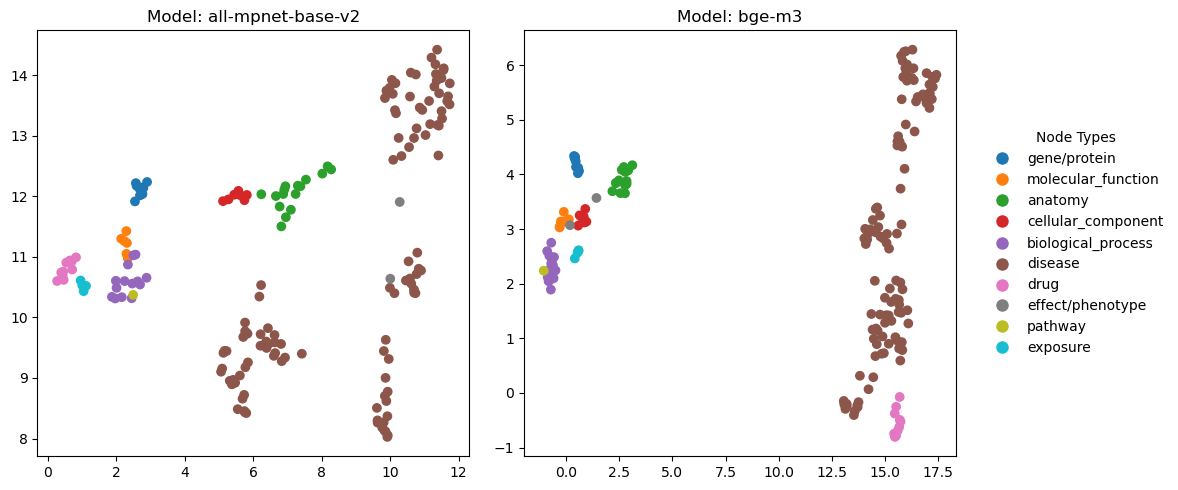

In [15]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def plot_subgraph_with_legend(subgraph_nodes, embedding_files):
    """
    Plot two subgraphs side by side with a single legend to the right.
    """
    # Create a figure with a GridSpec layout
    fig = plt.figure(figsize=(12, 5))  # Adjust figure size for better readability
    gs = GridSpec(1, 3, width_ratios=[1, 1, 0.3])  # Two plots and one space for the legend

    # Dictionary to collect labels and colors for the single legend
    label_to_num_global = {}

    # Iterate over embedding files and create two subplots
    for i, embedding_file in enumerate(embedding_files[:2]):  # Limit to two plots
        print(f"Loading file: {embedding_file}")
        # Load the embeddings for the current model
        with open(os.path.expanduser(f'~/scratch-llm/storage/nodes/{embedding_file}'), 'rb') as f:
            all_nodes_embedded = pickle.load(f)

        # Generate the subgraph
        subgraph_nodes = generate_subgraph(all_nodes_embedded)

        # Extract embeddings and labels
        embeddings = np.array([node.embedding for node in subgraph_nodes])
        labels = [node.metadata['node_type'] for node in subgraph_nodes]

        # Perform UMAP dimensionality reduction
        reducer = umap.UMAP(n_components=2, random_state=42)
        reduced_embeddings = reducer.fit_transform(embeddings)

        # Convert labels to numerical values for coloring
        for label in labels:
            if label not in label_to_num_global:
                label_to_num_global[label] = len(label_to_num_global)
        numeric_labels = [label_to_num_global[label] for label in labels]

        # Create a subplot for the current embedding file
        ax = fig.add_subplot(gs[i])
        scatter = ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=numeric_labels, cmap='tab10')

        if ".pkl" in embedding_file:
            embedding_file = embedding_file.replace(".pkl", "")
            embedding_file = embedding_file.replace("all_nodes_", "")
        ax.set_title(f"Model: {embedding_file.split('/')[-1]}")

    # Create a single legend in the third column
    legend_labels = list(label_to_num_global.keys())
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(label_to_num_global[label]), markersize=10) for label in legend_labels]
    legend_ax = fig.add_subplot(gs[2])
    legend_ax.axis('off')  # Turn off the axis for the legend space
    legend_ax.legend(handles, legend_labels, title="Node Types", loc="center", frameon=False)

    plt.tight_layout()
    plt.show()

embedding_files = [
    "all_nodes_all-mpnet-base-v2.pkl",
    "all_nodes_bge-m3.pkl",
    # "all_nodes_bge-small-en-v1.5.pkl",
    # "all_nodes_all-MiniLM-L6-v2.pkl",
    # "all_nodes_all-MiniLM-L12-v2.pkl",
]

# Call the function to plot the subgraph
plot_subgraph_with_legend(subgraph_nodes=None, embedding_files=embedding_files)

plot only diseases with labels

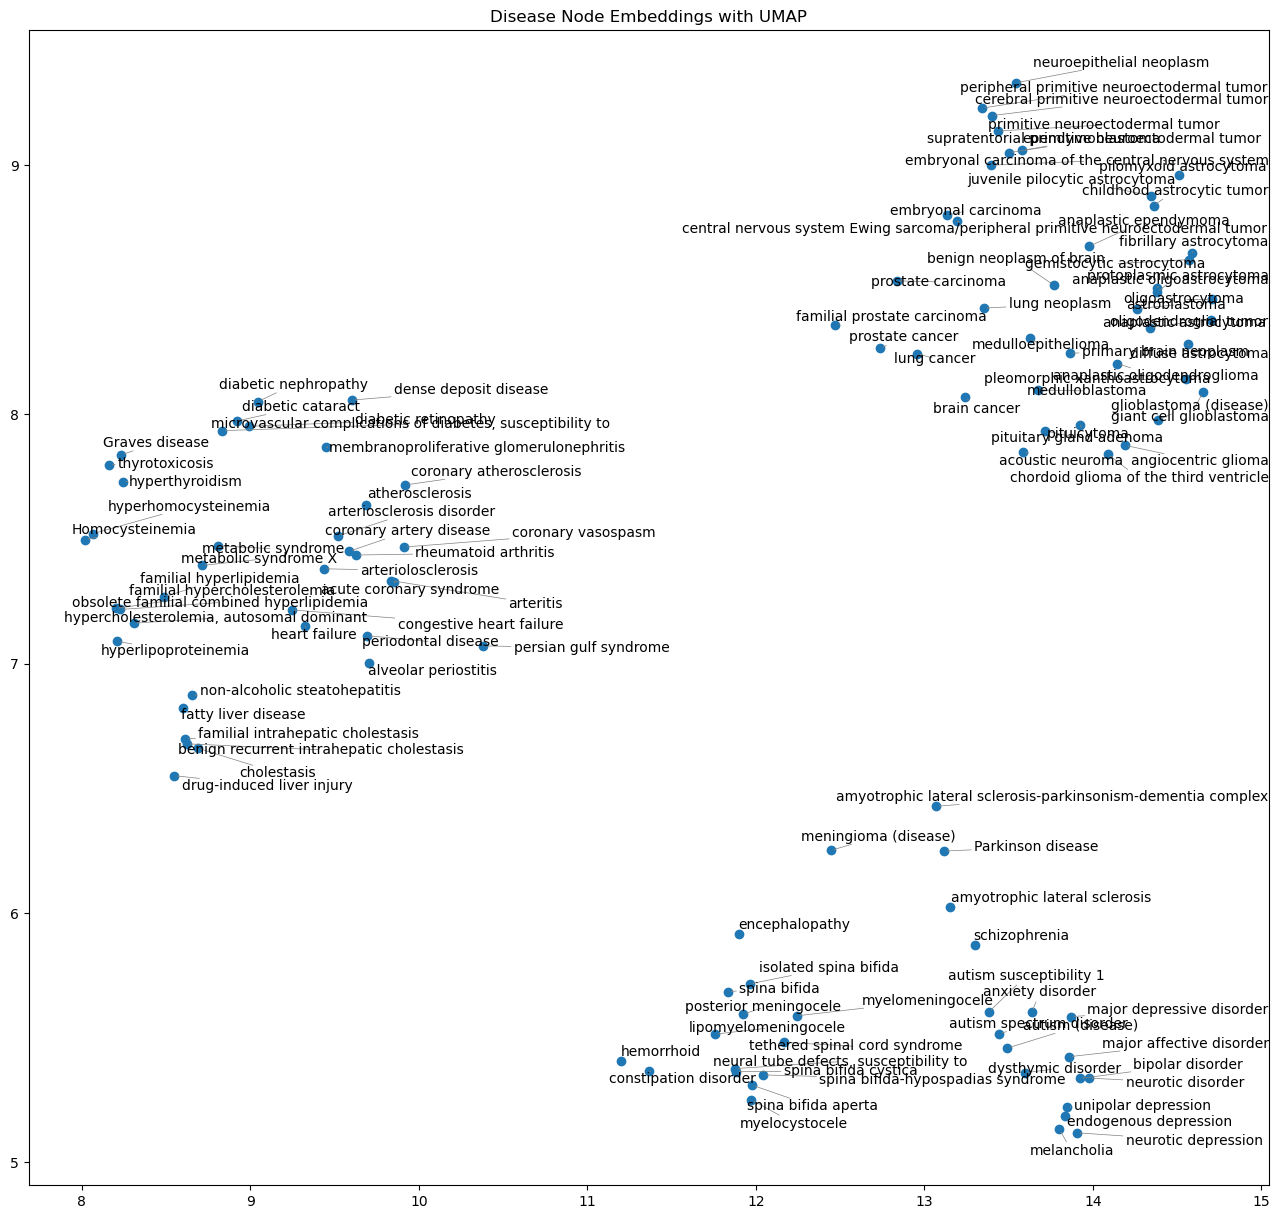

In [29]:
from adjustText import adjust_text  # label adjustment

# Plot the embeddings according to the "node_type" = 'disease' from the "reduced_embeddings" variable
disease_embeddings = []
disease_labels = []
for i, node in enumerate(subgraph_nodes):
    if node.metadata['node_type'] == 'disease':
        disease_embeddings.append(embeddings_reduced[i])
        disease_labels.append(node.metadata['node_name'])

# Plot the embeddings
disease_embeddings = np.array(disease_embeddings)
plt.figure(figsize=(16, 15))  # Increase the figure size
plt.scatter(disease_embeddings[:, 0], disease_embeddings[:, 1])

# Add labels and adjust their positions
texts = []
for i, txt in enumerate(disease_labels):
    texts.append(plt.text(disease_embeddings[i, 0], disease_embeddings[i, 1], txt))

adjust_text(texts, arrowprops=dict(arrowstyle="->", color='gray', lw=0.5))  # Adjust text positions

plt.title("Disease Node Embeddings with UMAP")
plt.show()

### All nodes

/home/lasa14/.conda/envs/llm-rag/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lasa14/.conda/envs/llm-rag/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


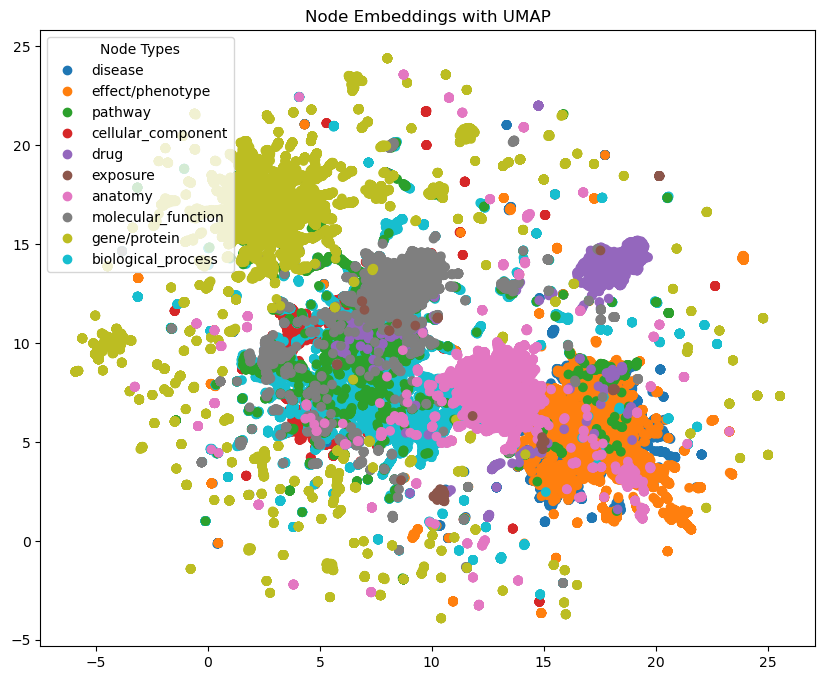

In [7]:
reducer = umap.UMAP(n_components=2, random_state=42)

embeddings = np.array([node.embedding for node in all_nodes_embedded])
embeddings_reduced = reducer.fit_transform(embeddings)
embeddings_reduced.shape


# plot the embeddings according to the "node_type" from the reduced_embeddings variable
plt.figure(figsize=(10, 8))  # Increase the figure size

# Convert labels to numerical values for coloring
labels = [node.metadata['node_type'] for node in all_nodes_embedded]
label_to_num = {label: idx for idx, label in enumerate(set(labels))}
numeric_labels = [label_to_num[label] for label in labels]

legend_labels = list(label_to_num.keys())

# Create a scatter plot of the reduced embeddings

scatter = plt.scatter(embeddings_reduced[:, 0], embeddings_reduced[:, 1], c=numeric_labels, cmap='tab10')
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Node Types", loc="upper left")
plt.title("Node Embeddings with UMAP")
plt.show()

## distance measures

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# Load a pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Replace with a biomedical model if needed

# Compute embeddings for node names
node_embeddings = model.encode(disease_names)

similarity = cosine_similarity(node_embeddings, node_embeddings)
np.fill_diagonal(similarity, 0)
max_sim = np.max(similarity)
max_idx = np.unravel_index(np.argmax(similarity), similarity.shape)
print(f"Max cosine similarity:", max_sim, (disease_names[max_idx[0]], disease_names[max_idx[1]]))

# Compute euclidean distances avoiding self-comparisons
distance = euclidean_distances(node_embeddings, node_embeddings)
np.fill_diagonal(distance, np.inf)
min_dist = np.min(distance)
min_idx = np.unravel_index(np.argmin(distance), distance.shape)
print(f"Min euclidean distance:", min_dist, (disease_names[min_idx[0]], disease_names[min_idx[1]]))

In [ ]:
similarity = cosine_similarity(disease_embeddings, disease_embeddings) #direct from the dimensionality reduction
np.fill_diagonal(similarity, 0)
max_sim = np.max(similarity)
max_idx = np.unravel_index(np.argmax(similarity), similarity.shape)
print(f"Max cosine similarity:", max_sim, (disease_labels[max_idx[0]], disease_labels[max_idx[1]]))

# Compute euclidean distances avoiding self-comparisons
distance = euclidean_distances(disease_embeddings, disease_embeddings)
np.fill_diagonal(distance, np.inf)
min_dist = distance.min()
min_idx = np.unravel_index(np.argmin(distance), distance.shape)
print(f"Min euclidean distance:", min_dist, (disease_labels[min_idx[0]], disease_labels[min_idx[1]]))


semantic similarity:
1. genenerate embeddings from the 'node_name', these embeddings should capture relationships among the terms grouping similar closer together.
2. calculate pairwise cosine similarity/Eucleidian distance
    - (both methods agree on the most similar pair, which corresponds to the same pair in the graph)

?? should I apply dimensionality reduction

comparison of both:
-   between the distance from the 'node_name' and the distance from the index
- the distance value for the same pair should be similar: large distance for pairs distant in the index and in the 'node_name'

## Temperature plot

In [ ]:
# calculate Pearson correlations among the embeddings in index_nodes
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt

index_nodes_embeddings = np.array([node.embedding for node in index_nodes])
correlations = np.corrcoef(index_nodes_embeddings)

#plot half of the correlation matrix with labels and correlation values
plt.figure(figsize=(10, 10))
plt.imshow(correlations, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(index_nodes)), [node.metadata['node_name'] for node in index_nodes], rotation=90)
plt.yticks(range(len(index_nodes)), [node.metadata['node_name'] for node in index_nodes])
plt.show()